In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import umap
from scipy import stats
from sklearn.decomposition import PCA
import joblib

# Making analysis datasets

In [2]:
# Get Alzheimer's Disease diagnosis information
alzcohort = pd.read_csv('ad_demographics.csv')
alzdiag = pd.read_csv('ad_diagnosis.csv')

# Get Control diagnosis information
concohort = pd.read_csv('control_demographics.csv')
condiag = pd.read_csv('control_diagnosis.csv')

## Change clounmns'name

In [3]:
alzcohort = alzcohort.rename(columns={'PatientDurableKey':'PatientID','estimated_age':'Age', 'FirstRace':'Race','Status':'Death_Status'})
alzdiag = alzdiag.rename(columns={'PatientDurableKey':'PatientID','estimated_age':'Age', 'FirstRace':'Race','Status':'Death_Status'})
concohort = concohort.rename(columns={'PatientDurableKey':'PatientID','estimated_age':'Age', 'FirstRace':'Race','Status':'Death_Status'})
condiag = condiag.rename(columns={'PatientDurableKey':'PatientID','estimated_age':'Age', 'FirstRace':'Race','Status':'Death_Status'})

## Make a pivot table

In [4]:
n = 'DiagnosisName'
alzdiag_pivot = pd.pivot_table(alzdiag[[n, 'PatientID']].drop_duplicates(), 
         values = [n], index = 'PatientID', columns = [n],
         aggfunc = lambda x: 1 if len(x)>0 else 0, fill_value = 0)
alzdiag_pivot['isAD'] = 1

In [5]:
n = 'DiagnosisName'
condiag_pivot = pd.pivot_table(condiag[[n, 'PatientID']].drop_duplicates(), 
         values = [n], index = 'PatientID', columns = [n],
         aggfunc = lambda x: 1 if len(x)>0 else 0, fill_value = 0)
condiag_pivot['isAD'] = 0
condiag_pivot

DiagnosisName,'light-for-dates' infant with signs of fetal malnutrition,(HFpEF) heart failure with preserved ejection fraction (HCC),(Idiopathic) normal pressure hydrocephalus (HCC),*Unknown,10 to 59 years of age,1st degree AV block,"2-part displaced fracture of surgical neck of left humerus, initial encounter for closed fracture","2-part displaced fracture of surgical neck of left humerus, subsequent encounter for fracture with routine healing",2nd degree AV block,3-vessel CAD,...,Zoster ophthalmicus,Zoster vaccine,Zoster without complications,"Zygomatic fracture, left side, initial encounter for closed fracture (HCC)","Zygomatic fracture, unspecified side, initial encounter for closed fracture (HCC)","Zygomatic fracture, unspecified side, initial encounter for open fracture (HCC)","Zygomatic fracture, unspecified side, subsequent encounter for fracture with routine healing",Zygomatic hyperplasia,Zygomycosis (phycomycosis or mucormycosis) (HCC),isAD
PatientID,,,,,,,,,,,,,,,,,,,,,
D00143BB9AA9B9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D0016B570412CD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D0019E9F85A3D6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D001DF6BA6A4E2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D002B22923F697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DFFE8107CDA348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DFFF1B8ED4683F,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DFFF226D09433C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
alldiag_pivot = pd.concat([alzdiag_pivot,condiag_pivot], axis = 0)

### Delete columns containing "Alzheimer" in the disease name

In [7]:
colstodrop = alldiag_pivot.columns[alldiag_pivot.columns.str.contains('alzheimer', flags=re.IGNORECASE)]

In [8]:
alldiag_pivot = alldiag_pivot.drop(colstodrop , axis=1)

### Calculate total number of non-AD complications

In [9]:
alldiag_pivot['#diagnosis'] = alldiag_pivot.loc[:, ~alldiag_pivot.columns.isin(['isAD'])].sum(axis=1)

<AxesSubplot:xlabel='#diagnosis', ylabel='Count'>

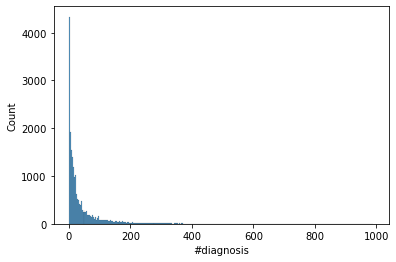

In [10]:
sns.histplot(alldiag_pivot, x= alldiag_pivot['#diagnosis'])

In [11]:
alldiag_pivot['#diagnosis'].describe()

count    21331.000000
mean        43.323942
std         70.986221
min          0.000000
25%          5.000000
50%         16.000000
75%         49.000000
max        990.000000
Name: #diagnosis, dtype: float64

### Join background table to Alldiag_pivot

In [12]:
demographic_cols = ['PatientID', 'Age', 'Sex', 'Race', 'Death_Status']

In [13]:
alldiag_pivot = alldiag_pivot.merge(pd.concat([alzcohort[demographic_cols], 
                                        concohort[demographic_cols]]).set_index('PatientID'),
                how = 'left', left_index = True, right_index = True)
alldiag_pivot = alldiag_pivot.fillna(0)

In [14]:
alldiag_pivot

,"""walking corpse"" syndrome",'light-for-dates' infant with signs of fetal malnutrition,(HFpEF) heart failure with preserved ejection fraction (HCC),(Idiopathic) normal pressure hydrocephalus (HCC),*Unknown,1st MTP arthritis,1st degree AV block,"2-part displaced fracture of surgical neck of right humerus, initial encounter for closed fracture","2-part displaced fracture of surgical neck of right humerus, subsequent encounter for fracture with routine healing","2-part nondisplaced fracture of surgical neck of left humerus, initial encounter for closed fracture",...,"Zygomatic fracture, left side, initial encounter for closed fracture (HCC)","Zygomatic fracture, unspecified side, initial encounter for open fracture (HCC)","Zygomatic fracture, unspecified side, subsequent encounter for fracture with routine healing",Zygomatic hyperplasia,Zygomycosis (phycomycosis or mucormycosis) (HCC),#diagnosis,Age_y,Sex,Race,Death_Status
PatientID,,,,,,,,,,,,,,,,,,,,,
D0003B2687D8F9,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7.0,88,Female,White or Caucasian,Alive
D000D5B83D9620,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,22.0,91,Female,White or Caucasian,Alive
D000D6884BD199,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,21.0,90,Male,White or Caucasian,Alive
D0016F824B7B74,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,85.0,91,Male,White or Caucasian,Deceased
D00195531E21B1,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,75.0,91,Female,Black or African American,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DFFE8107CDA348,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,118.0,91,Female,Black or African American,Deceased
DFFF1B8ED4683F,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,87,Female,White or Caucasian,Deceased
DFFF226D09433C,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,89,Female,White or Caucasian,Alive


In [15]:
alldiag_pivot = alldiag_pivot.drop("Age_x", axis=1)
alldiag_pivot=alldiag_pivot.rename(columns= {"Age_y":"Age"})

In [16]:
alldiag_pivot

,"""walking corpse"" syndrome",'light-for-dates' infant with signs of fetal malnutrition,(HFpEF) heart failure with preserved ejection fraction (HCC),(Idiopathic) normal pressure hydrocephalus (HCC),*Unknown,1st MTP arthritis,1st degree AV block,"2-part displaced fracture of surgical neck of right humerus, initial encounter for closed fracture","2-part displaced fracture of surgical neck of right humerus, subsequent encounter for fracture with routine healing","2-part nondisplaced fracture of surgical neck of left humerus, initial encounter for closed fracture",...,"Zygomatic fracture, left side, initial encounter for closed fracture (HCC)","Zygomatic fracture, unspecified side, initial encounter for open fracture (HCC)","Zygomatic fracture, unspecified side, subsequent encounter for fracture with routine healing",Zygomatic hyperplasia,Zygomycosis (phycomycosis or mucormycosis) (HCC),#diagnosis,Age,Sex,Race,Death_Status
PatientID,,,,,,,,,,,,,,,,,,,,,
D0003B2687D8F9,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7.0,88,Female,White or Caucasian,Alive
D000D5B83D9620,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,22.0,91,Female,White or Caucasian,Alive
D000D6884BD199,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,21.0,90,Male,White or Caucasian,Alive
D0016F824B7B74,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,85.0,91,Male,White or Caucasian,Deceased
D00195531E21B1,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,75.0,91,Female,Black or African American,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DFFE8107CDA348,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,118.0,91,Female,Black or African American,Deceased
DFFF1B8ED4683F,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,87,Female,White or Caucasian,Deceased
DFFF226D09433C,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,89,Female,White or Caucasian,Alive


# Dimentional Reduction

## (If necessary) Sampling from the dataset

In [17]:
alldiag_pivot_sp = alldiag_pivot

In [18]:
y = alldiag_pivot_sp["isAD"].replace({1:"Alzheimer", 0:"Control"})

In [19]:
demographic_cols = ['Age', 'Sex', 'Race', 'Death_Status','#diagnosis']

In [20]:
z = alldiag_pivot_sp[demographic_cols]
X = alldiag_pivot_sp.drop('isAD', axis=1).drop(demographic_cols, axis=1).astype('int32')

In [21]:
X

,"""walking corpse"" syndrome",'light-for-dates' infant with signs of fetal malnutrition,(HFpEF) heart failure with preserved ejection fraction (HCC),(Idiopathic) normal pressure hydrocephalus (HCC),*Unknown,1st MTP arthritis,1st degree AV block,"2-part displaced fracture of surgical neck of right humerus, initial encounter for closed fracture","2-part displaced fracture of surgical neck of right humerus, subsequent encounter for fracture with routine healing","2-part nondisplaced fracture of surgical neck of left humerus, initial encounter for closed fracture",...,Zenker diverticula,Zenker's hypopharyngeal diverticulum,Zonular dehiscence,Zoster iridocyclitis,Zoster vaccine,"Zygomatic fracture, left side, initial encounter for closed fracture (HCC)","Zygomatic fracture, unspecified side, initial encounter for open fracture (HCC)","Zygomatic fracture, unspecified side, subsequent encounter for fracture with routine healing",Zygomatic hyperplasia,Zygomycosis (phycomycosis or mucormycosis) (HCC)
PatientID,,,,,,,,,,,,,,,,,,,,,
D0003B2687D8F9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D000D5B83D9620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D000D6884BD199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D0016F824B7B74,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D00195531E21B1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DFFE8107CDA348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DFFF1B8ED4683F,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DFFF226D09433C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# PCA

In [22]:
pca = PCA(n_components= 2000, random_state=42)

In [23]:
mapper = pca.fit(X)

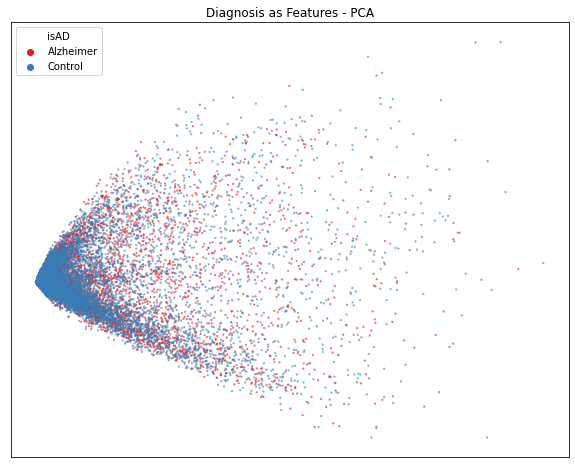

In [24]:
X_embedded = mapper.transform(X)

with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    sns.scatterplot(x= X_embedded[reordered_indices,0], y= X_embedded[reordered_indices,1],
    s= 5, linewidth= .0, alpha= .6,
    hue= y,
    hue_order= ["Alzheimer", "Control"])
    ax= plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white');
    plt.title('Diagnosis as Features - PCA')

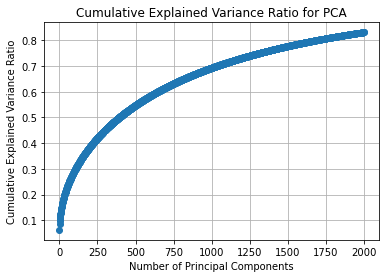

In [25]:
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio for PCA')
plt.grid(True)
plt.show()

## 1750 PCA components are included in the analysis dataset

## PCA(n=1750)

In [27]:
pca = PCA(n_components=1750, random_state=42)
data_pca = pca.fit_transform(X)

In [28]:
# Save the model
joblib.dump(pca, 'pca1750_model.joblib')

# Save the transformed data
np.save('data_pca1750_final1.npy', data_pca)


In [29]:
alldiag_pivot['Race'] = alldiag_pivot['Race'].astype(str)
alldiag_pivot.to_parquet('pivot_table_final1.parquet', engine='pyarrow')